In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sqlite3
import statsmodels.api as sm
from lin_reg import best_line



 - import everything up top in one
 - add release years for tmdb; filter by 2000 or later
 - merge into tmdb 
 - justify budget outliers 
 - outliers for revenue, both domestic and world 
 - low vote counts?
 - check for v prolific directors/writers
 - calculate the ROI
 

In [115]:
# Import TN Movie Budgets data
tn_movie_budgets = pd.read_csv('../data/tn.movie_budgets.csv.gz')

#Import TMDB data
tmdb_movies = pd.read_csv('../data/tmdb.movies.csv.gz')

#rt_reviews = pd.read_csv('../data/rt.reviews.tsv.gz', sep = '\t', encoding='latin-1')
#rt_movie_info = pd.read_csv('../data/rt.movie_info.tsv.gz', sep = '\t')
#movie_gross = pd.read_csv('../data/bom.movie_gross.csv.gz')

#con = sqlite3.connect('../data/im.db')



# (1.) Data Description  

## (1.i) TMDB Data

This data comes from The Movie Database (TMDB), which can be accessed [here](https://www.themoviedb.org/?language=en-US).

We can first check out our `tmdb_movies` data using a `.info()` and `.head()`. We can see that we have 26,517 rows to start, with 9 columns of data and an index column. We have some basic information about the film -- notably the name and release date -- as well as some metrics relating to popularity: `popularity`, `vote_average`, `vote_count`. 

In [116]:
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


We'll then do some basic data cleaning. We're eventually going to merge with a few other dataframes using the name of the film, so we're going to preemptively change the `title` column to be named `primary_title`. We'll also drop those columns of data which are unnecessary for our analysis. As we would expect, we still have our 26,517 records.

In [117]:
# Rename the title column to primary_title to match the other dataframes
tmdb_movies.rename(columns={'title': 'primary_title'}, inplace=True)
# Drop the columns that are not needed
tmdb_movies.drop(columns=['genre_ids', 'original_language', 'original_title'], inplace=True)
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     26517 non-null  int64  
 1   id             26517 non-null  int64  
 2   popularity     26517 non-null  float64
 3   release_date   26517 non-null  object 
 4   primary_title  26517 non-null  object 
 5   vote_average   26517 non-null  float64
 6   vote_count     26517 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 1.4+ MB


In [118]:
tmdb_movies['release_date'].value_counts().sort_index

<bound method Series.sort_index of 2010-01-01    269
2011-01-01    200
2012-01-01    155
2014-01-01    155
2013-01-01    145
             ... 
2009-10-30      1
1956-03-15      1
2016-02-15      1
2018-09-29      1
2010-06-02      1
Name: release_date, Length: 3433, dtype: int64>

## (1.ii) The Numbers Data

Our next dataset comes from The Numbers, which can be found [here](https://www.the-numbers.com/movie/budgets/all). 

We'll once again start off with a `.info()` and `.head()` so that we can get a sense of what's contained in the data. Here, we get some of our financial information. Specifically, we can see the reported `production_budget` of the movie, along with its `domestic_gross` and `worldwide_gross`. From here, we'll be able to compute a rudimentary (if somewhat flawed) return on investment (ROI) figure. 

In [119]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [120]:
tn_movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


We can also see that the `movie` column corresponds to the name of the film, so we will once again rename that column to `primary_title` so that we can perform merges later. Additionally, the financial columns are formatted as strings rather than integers. We will first strip the dollar signs and commas out of the string and then convert the columns to the integer datatype, so that we can more easily perform our analyses. We also will convert `release_date` to a `datetime` object, and from there extract both the month and year of release, and create the corresponding columns `release_month` and `release_year`.

In [121]:
# Rename the movie column to primary_title to match the other dataframes
tn_movie_budgets.rename(columns={'movie': 'primary_title'}, inplace=True)
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   primary_title      5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [122]:
# Convert the release_date column to a datetime object and create new columns for release_month and release_year
tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'])
tn_movie_budgets['release_month'] = pd.to_datetime(tn_movie_budgets['release_date']).dt.month_name()
tn_movie_budgets['release_year'] = pd.to_datetime(tn_movie_budgets['release_date']).dt.year

# Create a function to allow us to convert the columns to integers
def convert_to_int(df, column):
    df[column] = df[column].str.replace('$', '')
    df[column] = df[column].str.replace(',', '').astype(int)
    return df[column]

# Call the function for our three columns
convert_to_int(tn_movie_budgets, 'domestic_gross')
convert_to_int(tn_movie_budgets, 'worldwide_gross')
convert_to_int(tn_movie_budgets, 'production_budget')

# Check to make sure everything looks alright
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   primary_title      5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
 6   release_month      5782 non-null   object        
 7   release_year       5782 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 361.5+ KB


In [123]:
# We'll also order our months chronologically, so when we plot them, the x
# axis won't be in alphabetical order.
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
tn_movie_budgets['release_month'] = pd.Categorical(tn_movie_budgets['release_month'], categories=months, ordered=True)
tn_movie_budgets['release_month'].value_counts()

December     745
October      573
August       496
September    493
November     486
June         479
March        470
April        454
July         440
May          407
February     392
January      347
Name: release_month, dtype: int64

#### Removing zeroes

Within this dataset, we have a number of films for which there is no reported budget data. Since one of our chief concerns is the financial success of a film, the lack of data on these fronts makes those records useless. 

We first check to make sure that removing the data for which we have no budget information does not throw out an excessive number of records. We go from 5,782 entries to 5,234, so it seems pretty safe to remove the zeroes.

In [124]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   primary_title      5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
 6   release_month      5782 non-null   category      
 7   release_year       5782 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 322.4+ KB


In [125]:
tn_movie_budgets[tn_movie_budgets['domestic_gross'] != 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5234 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5234 non-null   int64         
 1   release_date       5234 non-null   datetime64[ns]
 2   primary_title      5234 non-null   object        
 3   production_budget  5234 non-null   int64         
 4   domestic_gross     5234 non-null   int64         
 5   worldwide_gross    5234 non-null   int64         
 6   release_month      5234 non-null   category      
 7   release_year       5234 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 332.6+ KB


In [126]:
# Since we don't lose too much data, we can go ahead and remove
# the zeroes.
tn_movie_budgets = tn_movie_budgets[tn_movie_budgets['domestic_gross'] != 0].copy()

One potentially problematic point is the spread of data for the `release_year`. Just from a preliminary look, we can see that there are a handful of films from the very early days of cinema. Since these will likely not have huge bearing on a start-up production company today, and since they constitute a very small proportion of our data, we can go ahead and filter them out. 

Below, you can see the distribution and count for our full dataset. We go from 5234 entries to 3865 entries.

In [127]:
tn_movie_budgets['release_year'].value_counts().sort_index()

1915      1
1916      1
1920      1
1925      2
1929      1
       ... 
2015    208
2016    192
2017    149
2018    137
2019     44
Name: release_year, Length: 92, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5234 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5234 non-null   int64         
 1   release_date       5234 non-null   datetime64[ns]
 2   primary_title      5234 non-null   object        
 3   production_budget  5234 non-null   int64         
 4   domestic_gross     5234 non-null   int64         
 5   worldwide_gross    5234 non-null   int64         
 6   release_month      5234 non-null   category      
 7   release_year       5234 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 332.6+ KB


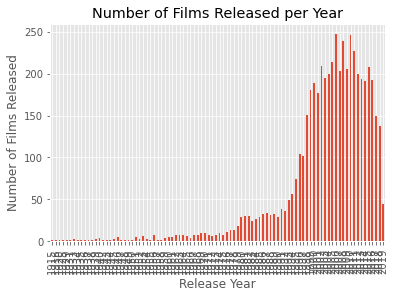

In [128]:

ax1 = tn_movie_budgets['release_year'].value_counts().sort_index().plot.bar()
ax1.set_title('Number of Films Released per Year')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Number of Films Released')

plt.style.use('ggplot')
tn_movie_budgets.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3865 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 3865 non-null   int64         
 1   release_date       3865 non-null   datetime64[ns]
 2   primary_title      3865 non-null   object        
 3   production_budget  3865 non-null   int64         
 4   domestic_gross     3865 non-null   int64         
 5   worldwide_gross    3865 non-null   int64         
 6   release_month      3865 non-null   category      
 7   release_year       3865 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 245.7+ KB


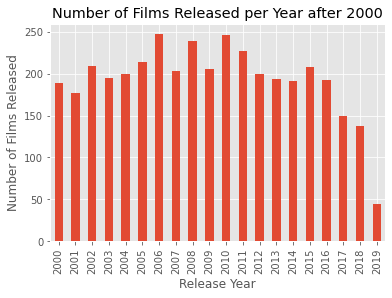

In [129]:
tn_2000 = tn_movie_budgets[tn_movie_budgets['release_year'] >= 2000].copy()

ax2 = tn_2000['release_year'].value_counts().sort_index().plot.bar()
ax2.set_title('Number of Films Released per Year after 2000')
ax2.set_xlabel('Release Year')
ax2.set_ylabel('Number of Films Released')


plt.style.use('ggplot')
tn_2000.info()

# So we'll save this filtering in place

tn_movie_budgets = tn_movie_budgets[tn_movie_budgets['release_year'] >= 2000].copy()
tn_movie_budgets.info()

# Removing zeros


In [130]:
# We have incomplete data, so we're dropping the rows which have a movie budget of 0
tn_movie_budgets_nonzero = tn_movie_budgets[tn_movie_budgets['domestic_gross'] != 0].copy()

In [131]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5234 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5234 non-null   int64         
 1   release_date       5234 non-null   datetime64[ns]
 2   primary_title      5234 non-null   object        
 3   production_budget  5234 non-null   int64         
 4   domestic_gross     5234 non-null   int64         
 5   worldwide_gross    5234 non-null   int64         
 6   release_month      5234 non-null   category      
 7   release_year       5234 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 332.6+ KB


In [132]:
# We can see that dropping the zero-budget movie only lost us 548 rows out of a total of 5782.
tn_movie_budgets_nonzero.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5234 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5234 non-null   int64         
 1   release_date       5234 non-null   datetime64[ns]
 2   primary_title      5234 non-null   object        
 3   production_budget  5234 non-null   int64         
 4   domestic_gross     5234 non-null   int64         
 5   worldwide_gross    5234 non-null   int64         
 6   release_month      5234 non-null   category      
 7   release_year       5234 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 332.6+ KB


# Removing Budget Outliers

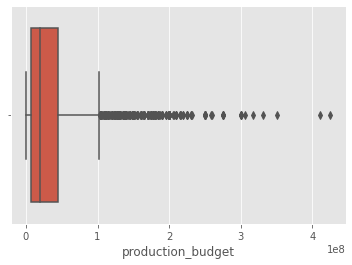

In [133]:
#Boxplot to visualize the outliers
sns.boxplot(x=tn_movie_budgets_nonzero['production_budget'])
plt.show()

In [134]:
# Calculating the first and third quartiles for production budget
Q1 = tn_movie_budgets_nonzero['production_budget'].quantile(0.25)
Q3 = tn_movie_budgets_nonzero['production_budget'].quantile(0.75)

# Calculating the Interquartile Range
IQR = Q3 - Q1

# Getting the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Removing the rows with production budget outliers
tn_movie_budgets_nonzero_no_outliers= tn_movie_budgets_nonzero.loc[(tn_movie_budgets_nonzero['production_budget'] >= lower_bound) & (tn_movie_budgets_nonzero['production_budget'] <= upper_bound)]


# Adding ROI Columns to Movie Budgets table

In [135]:
tn_movie_budgets_nonzero['domestic_ROI'] = ((tn_movie_budgets_nonzero['domestic_gross'] - tn_movie_budgets_nonzero['production_budget']) / tn_movie_budgets_nonzero['production_budget']) * 100

tn_movie_budgets_nonzero['worldwide_ROI'] = ((tn_movie_budgets_nonzero['worldwide_gross'] - tn_movie_budgets_nonzero['production_budget']) / tn_movie_budgets_nonzero['production_budget']) * 100


# SQL DB

In [136]:
# Importing the IMDB data and checking out the schema
conn = sqlite3.connect('../data/im.db')
pd.read_sql('SELECT name AS "Table Names" FROM sqlite_master WHERE type="table"', conn)

,Table Names
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [137]:
# Making the IMDB movie_basics table into a pandas df
imdb_movie_basics = pd.read_sql('SELECT * FROM movie_basics', conn)
imdb_movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [138]:
# Exploring how many individual directors are in the IMDB directors table
imdb_directors = pd.read_sql(
    """SELECT DISTINCT person_id
    FROM directors;
    """, conn)
imdb_directors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109253 entries, 0 to 109252
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   person_id  109253 non-null  object
dtypes: object(1)
memory usage: 853.7+ KB


In [139]:
# Exploring how many individual writers are in the IMDB writers table
imdb_writers = pd.read_sql(
    """SELECT DISTINCT person_id
    FROM writers;
    """, conn)
imdb_writers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122576 entries, 0 to 122575
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   person_id  122576 non-null  object
dtypes: object(1)
memory usage: 957.8+ KB


In [140]:
imdb_movie_akas = pd.read_sql('SELECT * FROM movie_akas', conn)
imdb_movie_akas.drop(columns=['is_original_title'], inplace=True)
imdb_movie_akas.head()

,movie_id,ordering,title,region,language,types,attributes
0,tt0369610,10,Джурасик свят,BG,bg,None,None
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None


In [141]:
#Renaming 'movie' column to 'primary_title' so I can join table with 'tn_movie_budgets' table
imdb_movie_akas = imdb_movie_akas.rename(columns={"title": "primary_title"})

In [142]:
imdb_movie_akas = imdb_movie_akas.dropna(subset=['attributes'])


# Creating Separate DataFrames for Experienced vs. Not-Experienced Directors and Writers

In [143]:
# DataFrame for not-experienced directors
d_n_e = pd.read_sql(
"""
SELECT m.averagerating, m.numvotes, d_e.person_id, b.primary_title
FROM movie_ratings AS m
    JOIN 
        (SELECT DISTINCT person_id, movie_id
        FROM directors
        GROUP BY person_id
        HAVING COUNT() <=3) AS d_e
    USING(movie_id)
    JOIN movie_basics AS b
    USING(movie_id)
""", conn)
d_n_e.describe(include='all')

,averagerating,numvotes,person_id,primary_title
count,39566.000000,39566.000000,39566,39566
unique,NaN,NaN,39566,34106
top,NaN,NaN,nm0647099,"Milano 55,1. Cronaca di una settimana di passioni"
freq,NaN,NaN,1,48
mean,6.515766,909.214224,NaN,NaN
std,1.491461,9040.204720,NaN,NaN
min,1.000000,5.000000,NaN,NaN
25%,5.600000,11.000000,NaN,NaN
50%,6.700000,29.000000,NaN,NaN
75%,7.600000,134.000000,NaN,NaN


In [144]:
# DataFrame for experienced directors
d_e = pd.read_sql(
"""
SELECT m.averagerating, m.numvotes, d_n_e.person_id, b.primary_title
FROM movie_ratings AS m
    JOIN 
        (SELECT DISTINCT person_id, movie_id
        FROM directors
        GROUP BY person_id
        HAVING COUNT() >3) AS d_n_e
    USING(movie_id)
    JOIN movie_basics AS b
    USING(movie_id)
""", conn)
d_e.describe(include='all')

,averagerating,numvotes,person_id,primary_title
count,12765.000000,1.276500e+04,12765,12765
unique,NaN,NaN,12765,10020
top,NaN,NaN,nm2694702,World of Death
freq,NaN,NaN,1,83
mean,6.159976,5.892464e+03,NaN,NaN
std,1.389006,3.771988e+04,NaN,NaN
min,1.000000,5.000000e+00,NaN,NaN
25%,5.400000,2.100000e+01,NaN,NaN
50%,6.300000,8.500000e+01,NaN,NaN
75%,7.100000,5.080000e+02,NaN,NaN


In [145]:
# DataFrame for not-experienced writers

w_n_e = pd.read_sql(
"""
SELECT m.averagerating, m.numvotes, w_n_e.person_id, b.primary_title
FROM movie_ratings as m
    JOIN 
        (SELECT DISTINCT person_id, movie_id
        FROM writers
        GROUP BY person_id
        HAVING COUNT() <=3) as w_n_e
    USING(movie_id)
    JOIN movie_basics AS b
    USING(movie_id)
""", conn)
w_n_e.describe(include='all')

,averagerating,numvotes,person_id,primary_title
count,63619.000000,6.361900e+04,63619,63619
unique,NaN,NaN,63619,40989
top,NaN,NaN,nm6093163,Hug an Atheist
freq,NaN,NaN,1,28
mean,6.274442,3.764226e+03,NaN,NaN
std,1.448698,2.859679e+04,NaN,NaN
min,1.000000,5.000000e+00,NaN,NaN
25%,5.400000,1.500000e+01,NaN,NaN
50%,6.400000,5.700000e+01,NaN,NaN
75%,7.300000,3.340000e+02,NaN,NaN


In [146]:
# DataFrame for experienced writers

w_e = pd.read_sql(
"""
SELECT m.averagerating, m.numvotes, w_e.person_id, b.primary_title
FROM movie_ratings as m
    JOIN 
        (SELECT DISTINCT person_id, movie_id
        FROM writers
        GROUP BY person_id
        HAVING COUNT() >3) as w_e
    USING(movie_id)
    JOIN movie_basics AS b
    USING(movie_id)
""", conn)
w_e.describe(include='all')

,averagerating,numvotes,person_id,primary_title
count,8434.000000,8.434000e+03,8434,8434
unique,NaN,NaN,8434,5387
top,NaN,NaN,nm4194449,World of Death
freq,NaN,NaN,1,46
mean,6.101672,9.022202e+03,NaN,NaN
std,1.395730,5.134912e+04,NaN,NaN
min,1.000000,5.000000e+00,NaN,NaN
25%,5.300000,2.100000e+01,NaN,NaN
50%,6.200000,9.700000e+01,NaN,NaN
75%,7.100000,6.335000e+02,NaN,NaN


In [147]:
# Merging the experienced directors DataFrame with tmdb_movies and tn.movie_budgets
merged_d_e = pd.merge(d_e, tmdb_movies, on='primary_title')
merged_d_e = pd.merge(merged_d_e, tn_movie_budgets, on='primary_title')
merged_d_e

,averagerating,numvotes,person_id,primary_title,Unnamed: 0,id_x,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,production_budget,domestic_gross,worldwide_gross,release_month,release_year
0,7.6,326657,nm0587955,Moneyball,2505,60308,15.393,2011-09-22,7.1,2255,15,2011-09-23,50000000,75605492,111300835,September,2011
1,7.0,85839,nm2648685,Another Earth,2633,55420,10.030,2011-07-22,6.7,853,48,2011-07-22,175000,1321194,2102779,July,2011
2,4.7,59914,nm0001774,Zoolander 2,17483,329833,12.997,2016-02-12,4.7,1374,64,2016-02-12,50000000,28848693,55348693,February,2016
3,7.2,28994,nm0000776,Chasing Mavericks,5517,82684,6.546,2012-10-26,7.0,329,67,2012-10-26,20000000,6002756,8300821,October,2012
4,5.7,9089,nm0015328,Jumping the Broom,2704,57119,8.477,2011-05-06,6.0,103,93,2011-05-06,7000000,37295394,38158601,May,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,4.4,5648,nm2411665,Khiladi 786,6157,147767,1.824,2012-12-07,4.7,16,12,2012-12-07,5600000,385422,14683763,December,2012
653,5.6,74979,nm0027271,Resident Evil: The Final Chapter,22654,173897,0.844,2017-01-27,5.9,1859,84,2017-01-27,40000000,26844692,314101190,January,2017
654,7.0,163279,nm0197855,Game Night,23908,445571,19.459,2018-02-23,6.9,2756,94,2018-02-23,37000000,69179066,117378084,February,2018
655,7.0,163279,nm0326246,Game Night,23908,445571,19.459,2018-02-23,6.9,2756,94,2018-02-23,37000000,69179066,117378084,February,2018


In [148]:
# Merging the not-experienced directors DataFrame with tmdb_movies and tn.movie_budgets
merged_d_n_e = pd.merge(d_n_e, tmdb_movies, on='primary_title')
merged_d_n_e = pd.merge(merged_d_n_e, tn_movie_budgets, on='primary_title')
merged_d_n_e

,averagerating,numvotes,person_id,primary_title,Unnamed: 0,id_x,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,production_budget,domestic_gross,worldwide_gross,release_month,release_year
0,7.0,1613,nm1464150,The Hammer,869,74447,1.961,2010-10-26,6.5,16,50,2008-03-21,850000,442638,442638,March,2008
1,6.5,13,nm4418339,The Hammer,869,74447,1.961,2010-10-26,6.5,16,50,2008-03-21,850000,442638,442638,March,2008
2,4.4,69199,nm0455078,Sex and the City 2,137,37786,9.986,2010-05-27,5.9,809,16,2010-05-27,95000000,95347692,294680778,May,2010
3,5.6,44490,nm2552536,Don't Be Afraid of the Dark,214,46261,8.405,2010-11-06,5.5,550,43,2011-08-26,25000000,24046682,39126427,August,2011
4,7.1,129443,nm0002339,Remember Me,92,23169,11.453,2010-03-12,7.1,2079,51,2010-03-12,16000000,19068240,56506120,March,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,5.7,37,nm0928316,Sisters,14294,266294,10.993,2015-12-18,5.9,922,57,2015-12-18,30000000,87044645,106030660,December,2015
921,4.9,632,nm2178754,The Sleepwalker,11910,244776,2.659,2014-01-20,4.1,9,2,2014-11-21,1100000,2636,2636,November,2014
922,7.7,1165,nm4717106,Phantom,8199,152259,7.211,2013-03-01,6.0,151,43,2013-03-01,18000000,1034589,1199510,March,2013
923,6.9,14122,nm0697656,Beyond the Lights,11333,241771,7.717,2014-11-14,7.0,238,16,2014-11-14,7000000,14618727,14618727,November,2014


In [149]:
# Merging the experienced writers DataFrame with tmdb_movies and tn.movie_budgets
merged_w_e = pd.merge(w_e, tmdb_movies, on='primary_title')
merged_w_e = pd.merge(merged_w_e, tn_movie_budgets, on='primary_title')
merged_w_e

,averagerating,numvotes,person_id,primary_title,Unnamed: 0,id_x,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,production_budget,domestic_gross,worldwide_gross,release_month,release_year
0,8.0,621193,nm1872664,The Revenant,14203,281957,19.410,2015-12-25,7.4,11064,27,2015-12-25,135000000,183637894,532938302,December,2015
1,8.0,621193,nm1872664,The Revenant,17411,281957,19.410,2015-12-25,7.4,11064,27,2015-12-25,135000000,183637894,532938302,December,2015
2,7.2,176699,nm0000092,The Croods,7914,49519,16.290,2013-03-22,6.8,3873,26,2013-03-22,135000000,187168425,573068425,March,2013
3,6.4,6466,nm0119989,Freakonomics,401,43942,5.705,2010-10-01,6.6,57,80,2010-10-01,2900000,101270,172867,October,2010
4,6.4,6466,nm1164861,Freakonomics,401,43942,5.705,2010-10-01,6.6,57,80,2010-10-01,2900000,101270,172867,October,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,4.4,5648,nm5244862,Khiladi 786,6157,147767,1.824,2012-12-07,4.7,16,12,2012-12-07,5600000,385422,14683763,December,2012
545,5.6,74979,nm0027271,Resident Evil: The Final Chapter,22654,173897,0.844,2017-01-27,5.9,1859,84,2017-01-27,40000000,26844692,314101190,January,2017
546,4.9,632,nm1227232,The Sleepwalker,11910,244776,2.659,2014-01-20,4.1,9,2,2014-11-21,1100000,2636,2636,November,2014
547,6.2,760,nm0502412,Out of the Blue,10024,281697,0.600,2013-10-01,10.0,1,23,2007-10-19,4600000,728,731767,October,2007


In [150]:
# Merging the not-experienced writers DataFrame with tmdb_movies and tn.movie_budgets
merged_w_n_e = pd.merge(w_n_e, tmdb_movies, on='primary_title')
merged_w_n_e = pd.merge(merged_w_n_e, tn_movie_budgets, on='primary_title')
merged_w_n_e

,averagerating,numvotes,person_id,primary_title,Unnamed: 0,id_x,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,production_budget,domestic_gross,worldwide_gross,release_month,release_year
0,4.2,50352,nm0001317,The Legend of Hercules,11096,188207,13.754,2014-01-10,4.5,805,42,2014-01-10,70000000,18848538,58953319,January,2014
1,4.2,50352,nm0316417,The Legend of Hercules,11096,188207,13.754,2014-01-10,4.5,805,42,2014-01-10,70000000,18848538,58953319,January,2014
2,4.2,50352,nm1048866,The Legend of Hercules,11096,188207,13.754,2014-01-10,4.5,805,42,2014-01-10,70000000,18848538,58953319,January,2014
3,7.0,1613,nm1559624,The Hammer,869,74447,1.961,2010-10-26,6.5,16,50,2008-03-21,850000,442638,442638,March,2008
4,7.0,1613,nm1670295,The Hammer,869,74447,1.961,2010-10-26,6.5,16,50,2008-03-21,850000,442638,442638,March,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2898,7.6,3004,nm4830779,Antarctica: A Year on Ice,8901,201132,2.061,2013-09-05,7.2,41,71,2014-11-28,1000000,288757,288757,November,2014
2899,7.0,163279,nm0991423,Game Night,23908,445571,19.459,2018-02-23,6.9,2756,94,2018-02-23,37000000,69179066,117378084,February,2018
2900,4.9,632,nm2178754,The Sleepwalker,11910,244776,2.659,2014-01-20,4.1,9,2,2014-11-21,1100000,2636,2636,November,2014
2901,6.9,14122,nm0697656,Beyond the Lights,11333,241771,7.717,2014-11-14,7.0,238,16,2014-11-14,7000000,14618727,14618727,November,2014


## Hypothesis Tests for Experienced vs. Not-Experienced Directors and Writers

In [151]:
merged_d_e.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 657 entries, 0 to 656
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   averagerating      657 non-null    float64       
 1   numvotes           657 non-null    int64         
 2   person_id          657 non-null    object        
 3   primary_title      657 non-null    object        
 4   Unnamed: 0         657 non-null    int64         
 5   id_x               657 non-null    int64         
 6   popularity         657 non-null    float64       
 7   release_date_x     657 non-null    object        
 8   vote_average       657 non-null    float64       
 9   vote_count         657 non-null    int64         
 10  id_y               657 non-null    int64         
 11  release_date_y     657 non-null    datetime64[ns]
 12  production_budget  657 non-null    int64         
 13  domestic_gross     657 non-null    int64         
 14  worldwide_

In [152]:
# Defining the variables for the ttests of directors

dx = merged_d_e['averagerating']
dx1 = merged_d_e['popularity']
dx2 = merged_d_e['vote_average']
dx3 = merged_d_e['domestic_gross'].values.astype(int)
dx4 = merged_d_e['worldwide_gross'].values.astype(int)

dy = merged_d_n_e['averagerating']
dy1 = merged_d_n_e['popularity']
dy2 = merged_d_n_e['vote_average']
dy3 = merged_d_n_e['domestic_gross'].values.astype(int)
dy4 = merged_d_n_e['worldwide_gross'].values.astype(int)


In [153]:
# Defining a ttest function

def ind_ttest(x, y):
    result = stats.ttest_ind(x, y, equal_var=False)
    return result

In [154]:
# director experience level vs. averagerating
ind_ttest(dx, dy)

Ttest_indResult(statistic=1.3014651455704358, pvalue=0.19330053275542636)

In [155]:
# director experience level vs. popularity
ind_ttest(dx1, dy1)

Ttest_indResult(statistic=10.637783143444354, pvalue=2.511609942256868e-25)

In [156]:
# director experience level vs. vote_average
ind_ttest(dx2, dy2)

Ttest_indResult(statistic=2.4774284457348297, pvalue=0.0133391804528393)

In [157]:
# director experience level vs. domestic_gross
ind_ttest(dx3, dy3)

Ttest_indResult(statistic=7.222637586011501, pvalue=9.655286428610816e-13)

In [158]:
# director experience level vs. worldwide_gross
ind_ttest(dx4, dy4)

Ttest_indResult(statistic=7.842988392282428, pvalue=1.1575653870804582e-14)

In [159]:
# defining the variables for the ttest of writers

wx = merged_w_e['averagerating']
wx1 = merged_w_e['popularity']
wx2 = merged_w_e['vote_average']
wx3 = merged_w_e['domestic_gross'].values.astype(int)
wx4 = merged_w_e['worldwide_gross'].values.astype(int)

wy = merged_w_n_e['averagerating']
wy1 = merged_w_n_e['popularity']
wy2 = merged_w_n_e['vote_average']
wy3 = merged_w_n_e['domestic_gross'].values.astype(int)
wy4 = merged_w_n_e['worldwide_gross'].values.astype(int)


In [160]:
# writer experience level vs. averagerating
ind_ttest(wx, wy)

Ttest_indResult(statistic=0.8740730080597775, pvalue=0.3823566630717634)

In [161]:
# writer experience level vs. popularity
ind_ttest(wx1, wy1)

Ttest_indResult(statistic=7.064452344452196, pvalue=4.071786135532789e-12)

In [162]:
# writer experience level vs. vote_average
ind_ttest(wx2, wy2)

Ttest_indResult(statistic=1.6397378790865889, pvalue=0.1014325469055464)

In [163]:
# writer experience level vs. domestic_gross
ind_ttest(wx3, wy3)

Ttest_indResult(statistic=7.706939855286846, pvalue=4.8229440307549907e-14)

In [164]:
# writer experience level vs. worldwide_gross
ind_ttest(wx4, wy4)

Ttest_indResult(statistic=8.495421963659876, pvalue=1.4075217387192703e-16)

# Getting DataFrames for Runtime and Budget Regressions

In [165]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5234 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5234 non-null   int64         
 1   release_date       5234 non-null   datetime64[ns]
 2   primary_title      5234 non-null   object        
 3   production_budget  5234 non-null   int64         
 4   domestic_gross     5234 non-null   int64         
 5   worldwide_gross    5234 non-null   int64         
 6   release_month      5234 non-null   category      
 7   release_year       5234 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 332.6+ KB


In [166]:
imdb_movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [167]:
movie_basics_budget = pd.merge(tn_movie_budgets, imdb_movie_basics, how ='inner', on='primary_title')
movie_basics_budget = pd.merge(movie_basics_budget, tmdb_movies, how ='inner', on='primary_title')
movie_basics_budget 

,id_x,release_date_x,primary_title,production_budget,domestic_gross,worldwide_gross,release_month,release_year,movie_id,original_title,start_year,runtime_minutes,genres,Unnamed: 0,id_y,popularity,release_date_y,vote_average,vote_count
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,December,2009,tt1775309,Abatâ,2011,93.0,Horror,6,19995,26.526,2009-12-18,7.4,18676
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,May,2011,tt1298650,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy",2470,1865,30.579,2011-05-20,6.4,8571
2,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,May,2015,tt2395427,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",14169,99861,44.383,2015-05-01,7.3,13457
3,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,April,2018,tt4154756,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",23811,299536,80.773,2018-04-27,8.3,13948
4,9,2017-11-17,Justice League,300000000,229024295,655945209,November,2017,tt0974015,Justice League,2017,120.0,"Action,Adventure,Fantasy",20623,141052,34.953,2017-11-17,6.2,7510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3836,38,2016-03-18,Krisha,30000,144822,144822,March,2016,tt4266638,Krisha,2015,83.0,Drama,18030,323929,5.288,2016-03-18,6.8,86
3837,45,2017-01-27,Emily,27000,3547,3547,January,2017,tt1863224,Emily,2011,NaN,Drama,10276,359406,0.600,2013-06-21,7.0,1
3838,45,2017-01-27,Emily,27000,3547,3547,January,2017,tt4393036,Emily,2017,83.0,Drama,10276,359406,0.600,2013-06-21,7.0,1
3839,45,2017-01-27,Emily,27000,3547,3547,January,2017,tt4883762,Emily,2013,26.0,Documentary,10276,359406,0.600,2013-06-21,7.0,1


In [168]:
movie_basics_budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3841 entries, 0 to 3840
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id_x               3841 non-null   int64         
 1   release_date_x     3841 non-null   datetime64[ns]
 2   primary_title      3841 non-null   object        
 3   production_budget  3841 non-null   int64         
 4   domestic_gross     3841 non-null   int64         
 5   worldwide_gross    3841 non-null   int64         
 6   release_month      3841 non-null   category      
 7   release_year       3841 non-null   int64         
 8   movie_id           3841 non-null   object        
 9   original_title     3840 non-null   object        
 10  start_year         3841 non-null   int64         
 11  runtime_minutes    3462 non-null   float64       
 12  genres             3771 non-null   object        
 13  Unnamed: 0         3841 non-null   int64         
 14  id_y    

In [169]:
movie_basics_budget.isna().sum()

id_x                   0
release_date_x         0
primary_title          0
production_budget      0
domestic_gross         0
worldwide_gross        0
release_month          0
release_year           0
movie_id               0
original_title         1
start_year             0
runtime_minutes      379
genres                70
Unnamed: 0             0
id_y                   0
popularity             0
release_date_y         0
vote_average           0
vote_count             0
dtype: int64

In [170]:
# Dropping nulls from runtime
movie_basics_budget.dropna(subset = ['runtime_minutes'], inplace=True)

In [171]:
movie_basics_budget['runtime_minutes'].isna().sum()

0

## Runtime and Budget Regressions and Visuals

In [221]:
# defining the variables for runtime and budget tests

x = sm.add_constant(movie_basics_budget['runtime_minutes'])
x1 = sm.add_constant(movie_basics_budget['production_budget'])
y = movie_basics_budget['worldwide_gross']
y1 = movie_basics_budget['popularity']
y2 = movie_basics_budget['vote_average']
y3 = movie_basics_budget['domestic_gross']


In [222]:
x1['production_budget']

0       425000000
1       410600000
2       330600000
3       300000000
4       300000000
          ...    
3835        30000
3836        30000
3838        27000
3839        27000
3840         9000
Name: production_budget, Length: 3462, dtype: int64

In [189]:
# Defining a linear regression function

def lin_reg(y, x):
    lin_reg_model = sm.OLS(y, x).fit().summary()
    return lin_reg_model

#### Budget Regressions

In [217]:
# budget vs. worldwide gross regression
lin_reg(y, x1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        worldwide_gross   R-squared (uncentered):                  11.180
Model:                            OLS   Adj. R-squared (uncentered):             11.183
Method:                 Least Squares   F-statistic:                             -3801.
Date:                Wed, 06 Dec 2023   Prob (F-statistic):                        1.00
Time:                        12:09:44   Log-Likelihood:                         -69667.
No. Observations:                3462   AIC:                                  1.393e+05
Df Residuals:                    3461   BIC:                                  1.393e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
production_budget     3.2598      0.035     93.515      0.000       3.191       3.328
==============================================================================
Omnibus:                     2091.834   Durbin-Watson:                   0.753
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38691.137
Skew:                           2.525   Prob(JB):                         0.00
Kurtosis:                      18.580   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

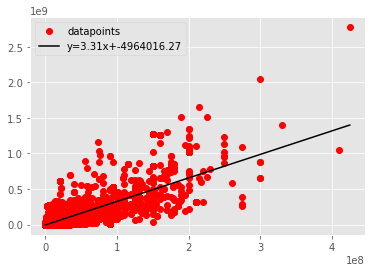

In [223]:
# budget vs. worldwide gross scatter
best_line(x1['production_budget'], y)

In [192]:
# budget vs. popularity
lin_reg(y1, x1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     701.4
Date:                Wed, 06 Dec 2023   Prob (F-statistic):          6.73e-141
Time:                        12:00:35   Log-Likelihood:                -11898.
No. Observations:                3462   AIC:                         2.380e+04
Df Residuals:                    3460   BIC:                         2.381e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.4240      0.162     39.605      0.000       6.106       6.742
production_budget  6.633e-08    2.5e-09     26.485      0.000    6.14e-08    7.12e-08
==============================================================================
Omnibus:                      761.934   Durbin-Watson:                   1.374
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3439.032
Skew:                           0.995   Prob(JB):                         0.00
Kurtosis:                       7.459   Cond. No.                     8.22e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.22e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

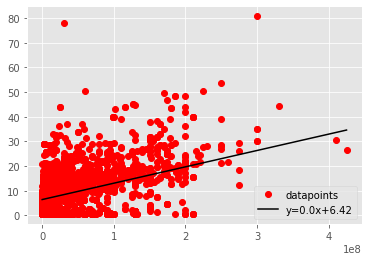

In [225]:
# budget vs. popularity scatter
best_line(x1['production_budget'], y1)

In [194]:
# budget vs. vote_average
lin_reg(y2, x1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           vote_average   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6625
Date:                Wed, 06 Dec 2023   Prob (F-statistic):              0.416
Time:                        12:00:35   Log-Likelihood:                -5629.7
No. Observations:                3462   AIC:                         1.126e+04
Df Residuals:                    3460   BIC:                         1.128e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.2357      0.027    235.043      0.000       6.184       6.288
production_budget  3.334e-10    4.1e-10      0.814      0.416    -4.7e-10    1.14e-09
==============================================================================
Omnibus:                      407.053   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1341.643
Skew:                          -0.588   Prob(JB):                    4.63e-292
Kurtosis:                       5.814   Cond. No.                     8.22e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.22e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

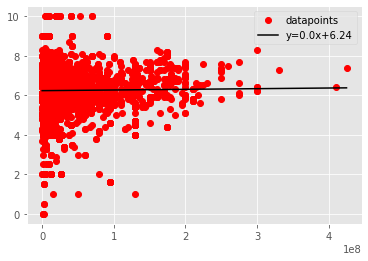

In [226]:
# budget vs. vote_average scatter
best_line(x1['production_budget'], y2)

In [196]:
# budget vs. domestic gross
lin_reg(y3, x1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     4041.
Date:                Wed, 06 Dec 2023   Prob (F-statistic):               0.00
Time:                        12:00:36   Log-Likelihood:                -66689.
No. Observations:                3462   AIC:                         1.334e+05
Df Residuals:                    3460   BIC:                         1.334e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              5.484e+06   1.21e+06      4.526      0.000    3.11e+06    7.86e+06
production_budget     1.1894      0.019     63.566      0.000       1.153       1.226
==============================================================================
Omnibus:                     1996.369   Durbin-Watson:                   0.600
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30955.572
Skew:                           2.428   Prob(JB):                         0.00
Kurtosis:                      16.821   Cond. No.                     8.22e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.22e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

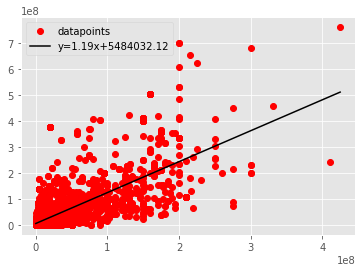

In [227]:
# budget vs. domestic gross scatter
best_line(x1['production_budget'], y3)

#### Runtime Regressions

In [198]:
# runtime vs. worldwide gross regression
lin_reg(y, x)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        worldwide_gross   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     20.39
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           6.52e-06
Time:                        12:00:37   Log-Likelihood:                -71321.
No. Observations:                3462   AIC:                         1.426e+05
Df Residuals:                    3460   BIC:                         1.427e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            7.505e+07    1.2e+07      6.242      0.000    5.15e+07    9.86e+07
runtime_minutes  5.358e+05   1.19e+05      4.516      0.000    3.03e+05    7.68e+05
==============================================================================
Omnibus:                     2586.254   Durbin-Watson:                   0.317
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50757.380
Skew:                           3.424   Prob(JB):                         0.00
Kurtosis:                      20.464   Cond. No.                         335.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

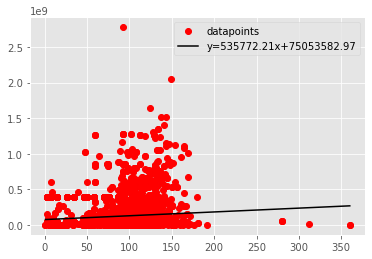

In [229]:
# runtime vs. worldwide gross scatter
best_line(x['runtime_minutes'], y)

In [200]:
# runtime vs. popularity regression
lin_reg(y1, x)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     304.8
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           1.78e-65
Time:                        12:00:38   Log-Likelihood:                -12071.
No. Observations:                3462   AIC:                         2.415e+04
Df Residuals:                    3460   BIC:                         2.416e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.6790      0.444      3.781      0.000       0.808       2.550
runtime_minutes     0.0765      0.004     17.458      0.000       0.068       0.085
==============================================================================
Omnibus:                     1157.149   Durbin-Watson:                   1.264
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5806.184
Skew:                           1.520   Prob(JB):                         0.00
Kurtosis:                       8.568   Cond. No.                         335.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

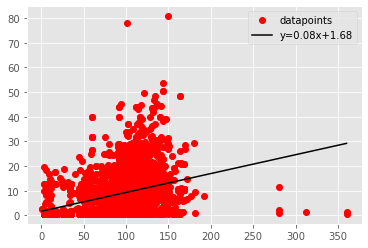

In [230]:
# runtime vs. popularity scatter
best_line(x['runtime_minutes'], y1)

In [186]:
# runtime vs. vote average regression
lin_reg(y2, x)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           vote_average   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     59.11
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           1.93e-14
Time:                        11:59:50   Log-Likelihood:                -5600.7
No. Observations:                3462   AIC:                         1.121e+04
Df Residuals:                    3460   BIC:                         1.122e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.7470      0.069     83.894      0.000       5.613       5.881
runtime_minutes     0.0052      0.001      7.688      0.000       0.004       0.007
==============================================================================
Omnibus:                      411.897   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1532.047
Skew:                          -0.559   Prob(JB):                         0.00
Kurtosis:                       6.061   Cond. No.                         335.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

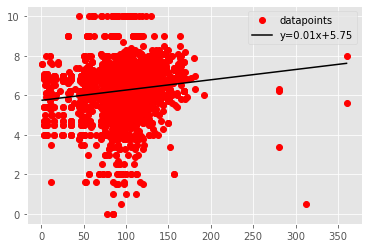

In [231]:
# runtime vs. vote_average scatter
best_line(x['runtime_minutes'], y2)

In [ ]:
# runtime vs. domestic gross regression
lin_reg(y3, x)

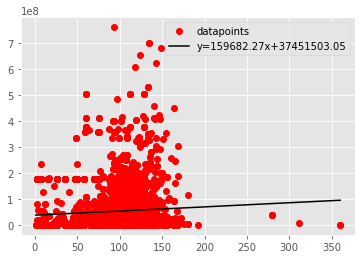

In [232]:
# runtime vs. domestic gross scatter
best_line(x['runtime_minutes'], y3)

# Combining Dataframes


In [ ]:
# Combing the IMDB 'movie_basics' table with the TMDB 'tmdb_movies' table

merged_movie_basics = pd.merge(imdb_movie_basics, tmdb_movies, on='primary_title')
merged_movie_basics.info()

In [ ]:
# Merge with the tn_movie_budgets dataframe
merged_movie_basics2 = pd.merge(merged_movie_basics, tn_movie_budgets, on='primary_title')
merged_movie_basics2.info()
# We lost a lot of rows of data here, so instead we might want to use a different dataframe

In [ ]:
#Combining SQL table 'movie_akas' with 'tn_movie_budgets'
movie_akas_budgets = pd.merge(movie_akas, tn_movie_budgets_nonzero_no_outliers, on = 'primary_title')
#Combining the combined dataframe 'movie_akas_budgets' with 'tmbd_movies' to get the popualarity and vote ratings
movieakas_budgets_popularity = pd.merge(movie_akas_budgets, tmdb_movies, on = 'primary_title')

In [ ]:
#Viewing the Series' in the dataframe to see which we may want to remove
movieakas_budgets_popularity.info()

In [ ]:
#Dropping columns from the merged "movie_akas_budgets" data frame that we will not need.
movieakas_budgets_popularity.drop(columns=['movie_id', 'ordering', 'region', 'language', 'types', 'Unnamed: 0', 'is_original_title', 'id_x', 'release_month', 'release_year', 'id_y', 'release_date_y'], inplace=True)

# Creating Tables With and Without 3-D Movies

In [ ]:
threed_budgets_df= movieakas_budgets_popularity[movieakas_budgets_popularity['attributes'].str.contains('3-D')]
no_threed_budgets_df= movieakas_budgets_popularity[movieakas_budgets_popularity['attributes'].str.contains('3-D')==False]

In [ ]:
#Dropping duplicate rows if release date and title match. Also including worldwide_gross as a criteria to make sure we are not deleting different releases
threed_budgets_df = threed_budgets_df.drop_duplicates(subset=['release_date_x', 'primary_title', 'worldwide_gross'])

no_threed_budgets_df = no_threed_budgets_df.drop_duplicates(subset=['release_date_x', 'primary_title', 'worldwide_gross'])

# Release Month


In [ ]:
tn_movie_budgets.groupby('release_month')['domestic_gross'].mean().sort_index(ascending=True).plot.bar()
plt.title('Average Domestic Gross by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Domestic Gross')
plt.xticks(rotation=45)
plt.style.use('ggplot');

In [ ]:
tn_movie_budgets.groupby('release_month')['worldwide_gross'].mean().plot.bar()
plt.title('Average World-Wide Gross by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Average World-Wide Gross (in million $)')
plt.xticks(rotation=45)
plt.style.use('ggplot');


In [ ]:
# Re-running after getting rid of films for which we lack budget information
tn_movie_budgets_nonzero.groupby('release_month')['domestic_gross'].mean().plot.bar()
plt.title('Average Domestic Gross by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Average Domestic Gross (in million $)')
plt.xticks(rotation=45)
plt.style.use('ggplot');

# Domestic Gross vs. Production Budget

In [ ]:
# Running first with the whole dataset
best_line(tn_movie_budgets['production_budget'], tn_movie_budgets['domestic_gross'])
# And then after filtering out zero-budget films
best_line(tn_movie_budgets_nonzero['production_budget'], tn_movie_budgets_nonzero['domestic_gross'])


# Years

In [ ]:
# For how many years do we have data?
merged_movie_basics.info()

In [ ]:
# The TN Data actually has everything we need for this analysis, although we'll 
# probably want to go in and do the same yearly filtering

tn_2000 = tn_movie_budgets[tn_movie_budgets['release_year'] >= 2000].copy()
tn_2000.info()

In [ ]:
# And we can do the same thing with our non-zero data
tn_2000 = tn_movie_budgets_nonzero[tn_movie_budgets_nonzero['release_year'] >= 2000].copy()
tn_2000_nonzero.info()

In [ ]:
# Graph the number of films we have per year
tn_2000_nonzero['release_year'].value_counts().sort_index().plot.bar()
plt.title('Number of Films Released per Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Films Released')
plt.xticks(rotation=45)
3plt.style.use('ggplot');

In [ ]:
# And then we can re-run our lin_reg function with the subsetted data

# Running first with the whole dataset
best_line(tn_2000['production_budget'], tn_2000['domestic_gross'])

# And then after filtering out zero-budget films
best_line(tn_2000_nonzero['production_budget'], tn_2000_nonzero['domestic_gross'])


# Visualizing the Mean Comparisons for 3-D and not 3-D groups

### We can use bar graphs to see how the means compare between the groups for different variables

In [ ]:
#Creating a Group Bar Chart Comparing the ROIs
categories = ['Domestic ROI', 'Worldwide ROI']
threed_means = [threed_budgets_df['domestic_ROI'].mean(), threed_budgets_df['worldwide_ROI'].mean() ]
no_threed_means = [no_threed_budgets_df['domestic_ROI'].mean(), no_threed_budgets_df['worldwide_ROI'].mean()]


# Set the positions of bars on X-axis
r1 = range(len(categories))
r2 = [x + bar_width for x in r1]

# Create the grouped bar plot
plt.bar(r1, threed_means, color='blue', width=bar_width, label='3-D Movies')
plt.bar(r2, no_threed_means, color='red', width=bar_width, label='Not 3-D Movies')

# Add labels, title, and legend
plt.xlabel('Metrics')
plt.ylabel('Mean Values (%)')
plt.title('ROI Comparison for 3-D and Not 3-D Movies')
plt.xticks([r + bar_width/2 for r in r1], categories)
plt.legend()

# Show the plot
plt.show()

In [ ]:
#Creating a Group Bar Chart Comparing the Gross Revenues
categories = ['Domestic Gross', 'Worldwide Gross']
threed_means = [threed_budgets_df['domestic_gross'].mean(), threed_budgets_df['worldwide_gross'].mean() ]
no_threed_means = [no_threed_budgets_df['domestic_gross'].mean(), no_threed_budgets_df['worldwide_gross'].mean()]

# Set the positions of bars on X-axis
r1 = range(len(categories))
r2 = [x + bar_width for x in r1]

# Create the grouped bar plot
plt.bar(r1, threed_means, color='blue', width=bar_width, label='3-D Movies')
plt.bar(r2, no_threed_means, color='red', width=bar_width, label='Not 3-D Movies')

# Add labels, title, and legend
plt.xlabel('Metrics')
plt.ylabel('Mean Values')
plt.title('ROI Comparison for 3-D and Not 3-D Movies')
plt.xticks([r + bar_width/2 for r in r1], categories)
plt.gca().set_yticklabels(['0', '$50,000,000', '$100,000,000', '$150,000,000', '$200,000,000', '$250,000,000'])
plt.legend()

# Show the plot
plt.show()

In [ ]:
#Creating a Group Bar Chart Comparing the Popularity Metrics
categories = ['Popularity', 'Vote Average']
threed_means = [threed_budgets_df['popularity'].mean(), threed_budgets_df['vote_average'].mean() ]
no_threed_means = [no_threed_budgets_df['popularity'].mean(), no_threed_budgets_df['vote_average'].mean()]


# Set the positions of bars on X-axis
r1 = range(len(categories))
r2 = [x + bar_width for x in r1]

# Create the grouped bar plot
plt.bar(r1, threed_means, color='blue', width=bar_width, label='3-D Movies')
plt.bar(r2, no_threed_means, color='red', width=bar_width, label='Not 3-D Movies')

# Add labels, title, and legend
plt.xlabel('Metrics')
plt.ylabel('Mean Values')
plt.title('ROI Comparison for 3-D and Not 3-D Movies')
plt.xticks([r + bar_width/2 for r in r1], categories)
plt.legend()

# Show the plot
plt.show()